In [1]:
import pickle
import pandas as pd
from us import states
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

from yf_backtester import YFCrossSectionalBT

# Ignore all warnings
warnings.filterwarnings("ignore")

## <font color="red"> Do not Run All. Please refer to specific sections and use the codes as required</font>

# [Strategy Implementation](#strat) Start Here
# [Strategy 1](#S1) Naive Long & Hold
# [Strategy 2](#S2) Insider - Company Relationship
# [Strategy 3](#S3) Insider Trade Size
# [Strategy 4](#S4) Insider Holding Ratio
# [Strategy 5](#S5) Signal Magnitude by Unique Insiders
# [Strategy 6](#S6) Signal Magnitude by Co-Location
# [Strategy 7](#S7) Winning Insider Strategy

## Function to parse form 3/4/5 data from SEC quarterly zip files

In [2]:
import pandas as pd
import numpy as np

def parser(year = 2023, quarter = 1, base_folder=r'data'):
    '''
    Go to https://www.sec.gov/dera/data/form-345, download the quarterly zip files and place the extracted 
    dataset in a "data" folder
    
    This function returns a merged dataframe of relevant columns from 8 TSVs for Insider Trading Alpha Signals.
    '''
    assert 2006 <= year <= 2023, "Year must be between 2006 and 2023"
    assert 1 <= quarter <= 4, "Quarter must be between 1 and 4"
    
    submission = pd.read_csv(f'{base_folder}/{year}q{quarter}_form345/SUBMISSION.tsv', delimiter='\t')
    repoting_owner = pd.read_csv(f'{base_folder}/{year}q{quarter}_form345/REPORTINGOWNER.tsv', delimiter='\t')
    non_deriv = pd.read_csv(f'{base_folder}/{year}q{quarter}_form345/NONDERIV_TRANS.tsv', delimiter='\t')
    
    merged = submission.merge(repoting_owner, how = "inner", on = "ACCESSION_NUMBER")\
    .merge(non_deriv, how = "inner", on = "ACCESSION_NUMBER")
    df = merged.loc[ : ,["ACCESSION_NUMBER", "FILING_DATE", "PERIOD_OF_REPORT", "ISSUERNAME",\
                    "ISSUERTRADINGSYMBOL","RPTOWNERCIK", "RPTOWNERNAME", "RPTOWNER_RELATIONSHIP",\
                         "RPTOWNER_CITY","RPTOWNER_STATE","TRANS_CODE", "TRANS_ACQUIRED_DISP_CD",\
                    "TRANS_SHARES", "TRANS_PRICEPERSHARE","SHRS_OWND_FOLWNG_TRANS", "SHRS_OWND_FOLWNG_TRANS","DIRECT_INDIRECT_OWNERSHIP",'DOCUMENT_TYPE']]

    return df

In [3]:
help(parser)

## Execute a loop to process the dataset from 2006 Q1 to 2023 Q1

In [4]:
import pandas as pd

all_dataframes = []

for year in range(2006, 2024):  # 2024 is used here so that 2023 is included
    for quarter in range(1, 5):
        try:
            df = parser(year, quarter)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error processing data for year {year}, quarter {quarter}: {e}")
            continue

# concatenate all dataframes into a single dataframe
final_df = pd.concat(all_dataframes, ignore_index=True)

# save the final dataframe as a pickle file
final_df.to_pickle('insider_df.pkl')

## Function to fetch historical data on tickers in dataset, and catch those not available in an array

In [5]:
import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def download_ticker(ticker, start_date='2006-01-01', end_date='2023-12-31'):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Ticker'] = ticker
        return data
    except Exception as e:
        print(f"No data available for ticker: {ticker}")
        return None

def fetch_ticker_data(tickers):
    ticker_df = pd.DataFrame()
    unavailable_tickers = []

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(download_ticker, ticker): ticker for ticker in tickers}
        for future in concurrent.futures.as_completed(futures):
            ticker = futures[future]
            try:
                data = future.result()
                if data is not None:
                    ticker_df = ticker_df.append(data)
                else:
                    unavailable_tickers.append(ticker)
            except Exception as e:
                print(f"Error downloading data for ticker: {ticker}")
                unavailable_tickers.append(ticker)
                
    return ticker_df, unavailable_tickers


## Store historical market data & missing tickers in a pickle

In [6]:
market_data, missing_tickers = fetch_ticker_data(unique_symbols)

In [7]:
market_data.to_pickle('market_data.pkl')
missing_tickers.to_pickle('missing_tickers.pkl')

## Function to remove rows of tickers without yfinance coverage from the dataset

In [8]:
def remove_unavailable_tickers(df, unavailable_tickers):
    # We use the ~ operator to invert the condition, this will return a dataframe where
    # the ISSUERTRADINGSYMBOL is not in the unavailable_tickers list
    df_filtered = df[~df['ISSUERTRADINGSYMBOL'].isin(unavailable_tickers)]
    return df_filtered

In [9]:
filtered_df = remove_unavailable_tickers(final_df, unavailable_tickers)

In [10]:
filtered_df.to_pickle('filtered_df.pkl')

In [11]:
filtered_df

# <a id='strat'>Strategy implementation</a>

## Function to return a slice of dataframe for given ticker / insider

In [12]:
def filter_dataframe(df, issuertradingsymbol=None, rptownercik=None, ):
    # create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()
    
    # filter based on ISSUERTRADINGSYMBOL if provided
    if issuertradingsymbol is not None:
        df_copy = df_copy[df_copy['ISSUERTRADINGSYMBOL'] == issuertradingsymbol]
        
    # filter based on RPTOWNERCIK if provided
    if rptownercik is not None:
        df_copy = df_copy[df_copy['RPTOWNERCIK'] == rptownercik]
    
    return df_copy

## Display dataframe structure & add S&P500 + Russell 1000 flags to corresponding tickers

In [13]:
final_df = pd.read_pickle("insider_df.pkl")
final_df["ISSUERTRADINGSYMBOL"] = final_df["ISSUERTRADINGSYMBOL"].astype("str")
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7446561 entries, 0 to 7446560
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ACCESSION_NUMBER           object 
 1   FILING_DATE                object 
 2   PERIOD_OF_REPORT           object 
 3   ISSUERNAME                 object 
 4   ISSUERTRADINGSYMBOL        object 
 5   RPTOWNERCIK                int64  
 6   RPTOWNERNAME               object 
 7   RPTOWNER_RELATIONSHIP      object 
 8   RPTOWNER_CITY              object 
 9   RPTOWNER_STATE             object 
 10  TRANS_CODE                 object 
 11  TRANS_ACQUIRED_DISP_CD     object 
 12  TRANS_SHARES               float64
 13  TRANS_PRICEPERSHARE        float64
 14  SHRS_OWND_FOLWNG_TRANS     float64
 15  SHRS_OWND_FOLWNG_TRANS     float64
 16  DIRECT_INDIRECT_OWNERSHIP  object 
 17  DOCUMENT_TYPE              object 
dtypes: float64(4), int64(1), object(13)
memory usage: 1022.6+ MB


## Parse the S&P 500 Indicators 

In [14]:
sp_500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp_500
cik = []
for i in range(len(sp_500["CIK"])):
    temp = str(sp_500["CIK"][i])
    while len(temp) != 10:
        temp = "0" + temp
    cik.append(temp)
sp_500["CIK"] = pd.Series(cik)

## Convert the headquarters state name from S&P dataframe to capitalized abbreviation

In [15]:
def convert_state(state_input):
    if len(state_input) == 2:
        # Assume input is state abbreviation
        matching_states = [state.name for state in states.STATES_AND_TERRITORIES if state.abbr == state_input.upper()]
        return matching_states[0] if matching_states else 'NA'
    else:
        # Assume input is state name
        matching_states = [state.abbr for state in states.STATES_AND_TERRITORIES if state.name.lower() == state_input.lower()]
        return matching_states[0] if matching_states else 'NA'


In [16]:
sp_500['State'] = sp_500['Headquarters Location'].apply(
    lambda x: convert_state(x.split(",")[1].strip()) if "," in x else 'NA')
sp_500['State'] = np.where(sp_500['Headquarters Location'] == 'Washington, D.C.', 'DC', sp_500['State'])

In [17]:
sp_500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,State
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,MN
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,WI
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,IL
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),IL
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,NA
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,0001041061,1997,KY
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,0000877212,1969,IL
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,0001136869,1927,IN
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,0000109380,1873,UT


## Parse the Russell 1000 Indicators 

In [18]:
Russell_1000 = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")[2]
final_df['S&P500'] = final_df["ISSUERTRADINGSYMBOL"].isin(sp_500['Symbol'])
final_df['R1000'] = final_df["ISSUERTRADINGSYMBOL"].isin(Russell_1000['Ticker'])
final_df[final_df['R1000'] == True]

,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_CITY,RPTOWNER_STATE,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000
52,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,S,D,600.00,28.26,54141.00,54141.00,D,4,True,True
53,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,S,D,600.00,28.27,53541.00,53541.00,D,4,True,True
54,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,S,D,500.00,28.28,53041.00,53041.00,D,4,True,True
55,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,S,D,100.00,28.29,52941.00,52941.00,D,4,True,True
56,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,S,D,200.00,28.30,52741.00,52741.00,D,4,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7446552,0001701605-23-000031,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,Officer,HOUSTON,TX,M,A,5866.00,NaN,11935.00,11935.00,D,4,True,True
7446553,0001701605-23-000031,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,Officer,HOUSTON,TX,F,D,2758.00,31.02,9177.00,9177.00,D,4,True,True
7446558,0000899243-23-003131,01-FEB-2023,26-JAN-2023,Targa Resources Corp.,TRGP,1659146,Pryor D. Scott,Officer,HOUSTON,TX,G,D,55300.00,0.00,58366.00,58366.00,D,4,True,True
7446559,0000899243-23-003131,01-FEB-2023,26-JAN-2023,Targa Resources Corp.,TRGP,1659146,Pryor D. Scott,Officer,HOUSTON,TX,G,A,55300.00,0.00,136533.00,136533.00,I,4,True,True


In [19]:
AAPL = filter_dataframe(final_df, issuertradingsymbol='AAPL')
GOOG = filter_dataframe(final_df, issuertradingsymbol='GOOG')

In [20]:
AAPL

,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_CITY,RPTOWNER_STATE,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000
12865,0001181431-06-020270,28-MAR-2006,24-MAR-2006,APPLE COMPUTER INC,AAPL,1214107,OPPENHEIMER PETER,Officer,CUPERTINO,CA,F,D,114375.0,59.96,149768.0,149768.0,D,4,True,True
12866,0001181431-06-020270,28-MAR-2006,24-MAR-2006,APPLE COMPUTER INC,AAPL,1214107,OPPENHEIMER PETER,Officer,CUPERTINO,CA,M,A,250000.0,NaN,149768.0,149768.0,D,4,True,True
13051,0001181431-06-020291,28-MAR-2006,24-MAR-2006,APPLE COMPUTER INC,AAPL,1214156,COOK TIMOTHY D,Officer,CUPERTINO,CA,S,D,2000.0,59.98,12597.0,12597.0,D,4,True,True
13052,0001181431-06-020291,28-MAR-2006,24-MAR-2006,APPLE COMPUTER INC,AAPL,1214156,COOK TIMOTHY D,Officer,CUPERTINO,CA,S,D,2000.0,59.98,12597.0,12597.0,D,4,True,True
13053,0001181431-06-020291,28-MAR-2006,24-MAR-2006,APPLE COMPUTER INC,AAPL,1214156,COOK TIMOTHY D,Officer,CUPERTINO,CA,S,D,4000.0,59.99,12597.0,12597.0,D,4,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435719,0000320193-23-000015,03-FEB-2023,01-FEB-2023,Apple Inc.,AAPL,1182047,BELL JAMES A,Director,CUPERTINO,CA,M,A,1685.0,NaN,36675.0,36675.0,D,4,True,True
7435834,0000320193-23-000018,03-FEB-2023,01-FEB-2023,Apple Inc.,AAPL,1051401,JUNG ANDREA,Director,CUPERTINO,CA,M,A,1685.0,NaN,49937.0,49937.0,D,4,True,True
7435936,0000320193-23-000020,03-FEB-2023,01-FEB-2023,Apple Inc.,AAPL,1179864,LOZANO MONICA C,Director,CUPERTINO,CA,M,A,1685.0,NaN,5239.0,5239.0,D,4,True,True
7435986,0000320193-23-000016,03-FEB-2023,01-FEB-2023,Apple Inc.,AAPL,1224944,GORE ALBERT JR,Director,CUPERTINO,CA,M,A,1685.0,NaN,467143.0,467143.0,D,4,True,True


## Filter the universe to S&P or Russell 1000

In [21]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()] # removing duplicate columns
final_df

,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_CITY,RPTOWNER_STATE,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000
0,0001179110-06-007504,31-MAR-2006,30-MAR-2006,WESTERN GAS RESOURCES INC,WGR,1354703,Gagnon Paul G,Officer,DENVER,CO,S,D,1666.00,49.40,5560.00,D,4,False,False
1,0001179110-06-007504,31-MAR-2006,30-MAR-2006,WESTERN GAS RESOURCES INC,WGR,1354703,Gagnon Paul G,Officer,DENVER,CO,M,A,1666.00,35.21,7226.00,D,4,False,False
2,0001011438-06-000246,31-MAR-2006,31-DEC-2004,GRANITE BROADCASTING CORP,GBTVK,1240223,DEUSHANE JOHN,Officer,NEW YORK,NY,M,A,1723.00,NaN,180325.00,D,4,False,False
3,0001011438-06-000246,31-MAR-2006,31-DEC-2004,GRANITE BROADCASTING CORP,GBTVK,1240223,DEUSHANE JOHN,Officer,NEW YORK,NY,D,D,1723.00,0.40,178602.00,D,4,False,False
4,0001011438-06-000246,31-MAR-2006,31-DEC-2004,GRANITE BROADCASTING CORP,GBTVK,1240223,DEUSHANE JOHN,Officer,NEW YORK,NY,J,A,49162.00,NaN,227764.00,D,4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7446556,0001127602-23-002963,01-FEB-2023,30-JAN-2023,ENTERPRISE FINANCIAL SERVICES CORP,EFSC,1550076,PONDER MARK G,Officer,CLAYTON,MO,M,A,531.00,0.00,9498.00,D,4,False,False
7446557,0001127602-23-002963,01-FEB-2023,30-JAN-2023,ENTERPRISE FINANCIAL SERVICES CORP,EFSC,1550076,PONDER MARK G,Officer,CLAYTON,MO,F,D,1358.00,51.82,10674.00,D,4,False,False
7446558,0000899243-23-003131,01-FEB-2023,26-JAN-2023,Targa Resources Corp.,TRGP,1659146,Pryor D. Scott,Officer,HOUSTON,TX,G,D,55300.00,0.00,58366.00,D,4,True,True
7446559,0000899243-23-003131,01-FEB-2023,26-JAN-2023,Targa Resources Corp.,TRGP,1659146,Pryor D. Scott,Officer,HOUSTON,TX,G,A,55300.00,0.00,136533.00,I,4,True,True


## Slice the final_df to S&P and Russell 1000 Universe

In [22]:
SNP = final_df[final_df["S&P500"] == True]
SNP = SNP[(SNP['TRANS_CODE'] != 'G') & (SNP['TRANS_CODE'] != 'A')]
SNP.reset_index(drop = True, inplace=True)
R1 = final_df[final_df["R1000"] == True]
R1 = R1[(R1['TRANS_CODE'] != 'G') & (R1['TRANS_CODE'] != 'A')]
R1.reset_index(drop = True, inplace=True)

In [23]:
SNP = SNP.merge(sp_500[['Symbol', 'State']], left_on='ISSUERTRADINGSYMBOL', right_on='Symbol', how='left')
SNP['State'].fillna('NA', inplace=True)
SNP['Co-location'] = SNP['State'] == SNP['RPTOWNER_STATE']
SNP.drop(columns='Symbol',inplace = True)

In [24]:
SNP.columns

Index(['ACCESSION_NUMBER', 'FILING_DATE', 'PERIOD_OF_REPORT', 'ISSUERNAME',
       'ISSUERTRADINGSYMBOL', 'RPTOWNERCIK', 'RPTOWNERNAME',
       'RPTOWNER_RELATIONSHIP', 'RPTOWNER_CITY', 'RPTOWNER_STATE',
       'TRANS_CODE', 'TRANS_ACQUIRED_DISP_CD', 'TRANS_SHARES',
       'TRANS_PRICEPERSHARE', 'SHRS_OWND_FOLWNG_TRANS',
       'DIRECT_INDIRECT_OWNERSHIP', 'DOCUMENT_TYPE', 'S&P500', 'R1000',
       'State', 'Co-location'],
      dtype='object')

In [25]:
SNP

,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_CITY,RPTOWNER_STATE,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,Officer,LOS GATOS,CA,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,Officer,BALTIMORE,MD,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,Officer,BALTIMORE,MD,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,Director,BUFFALO,NY,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,Officer,HOUSTON,TX,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [26]:
data = SNP.copy()

In [27]:
signal = []
for i in data["TRANS_ACQUIRED_DISP_CD"]:
    if i == "A":
        signal.append(1)
    else:
        signal.append(-1)

In [28]:
data.insert(1, "FILLINGDATE", pd.to_datetime(data["FILING_DATE"]))
data.insert(1, "YEAR", (pd.to_datetime(data["FILING_DATE"]).dt.year))
data.insert(1, "SIGNAL", signal)

In [29]:
data

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [30]:
data = data.dropna(subset = ["ISSUERTRADINGSYMBOL"]).reset_index(drop = True)
data = data.replace('BRK.B', 'BRK-B')
data

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [31]:
data.isna().sum()

ACCESSION_NUMBER                 0
SIGNAL                           0
YEAR                             0
FILLINGDATE                      0
FILING_DATE                      0
PERIOD_OF_REPORT                 0
ISSUERNAME                     181
ISSUERTRADINGSYMBOL              0
RPTOWNERCIK                      0
RPTOWNERNAME                   181
RPTOWNER_RELATIONSHIP           11
RPTOWNER_CITY                18156
RPTOWNER_STATE               21471
TRANS_CODE                       0
TRANS_ACQUIRED_DISP_CD           0
TRANS_SHARES                     0
TRANS_PRICEPERSHARE          21041
SHRS_OWND_FOLWNG_TRANS          42
DIRECT_INDIRECT_OWNERSHIP        0
DOCUMENT_TYPE                    0
S&P500                           0
R1000                            0
State                            0
Co-location                      0
dtype: int64

## <a id="S1">Strat 1 (Only long and hold)</a>

In [32]:
strat1 = data.copy()

In [33]:
from collections import Counter

def overall_train_test(data, train_year = 13):
    optimal_holding_dict = {}
    for i in range(2006, 2006+train_year):
        daily_returns = returns_collector(data, i).sum()
        optimal_holding = daily_returns[daily_returns == daily_returns.max()].index[0]
        optimal_holding_dict.update({i : optimal_holding})

    values = list(optimal_holding_dict.values())
    counter = Counter(values)
    most_common = counter.most_common()

    # Find the lowest value among the most frequent values
    most_frequent_values = [value for value, count in most_common if count == most_common[0][1]]
    holding_period = min(most_frequent_values)    
    report_dict = {}
    for train in range(2019,2024):
        result = signal2portfolio(returns_collector(data, train))
        report_dict[train] = result
    combined_df = pd.concat(report_dict.values())
    return backtester.backtest(combined_df, delay=1, holding_period= holding_period)

def rolling_method(data):
    report_dict = {}
    for i in range(2006, 2023):
        daily_returns = returns_collector(data, i)
        total_returns = daily_returns.sum()[1:]
        optimal_holding = total_returns[total_returns == total_returns.max()].index[0] # this should return optimal holding for 2006
        result = backtester.backtest(signal2portfolio(daily_returns), delay=1, holding_period=optimal_holding)
        report_dict[i + 1] = result.quick_report()
    combined_df = pd.concat(report_dict.values(), keys = report_dict.keys())
    return combined_df.unstack().reorder_levels([1, 0], axis=1).stack()

In [34]:
def signal2portfolio(signaldf):
    temp = signaldf.loc[:,[0]]
    temp.loc[:,[0]] = 1
    temp = temp.groupby('FILLINGDATE', group_keys=False).apply(lambda x: x/x.sum())
    temp = temp.unstack().fillna(0)
    temp.columns = temp.columns.get_level_values(1)
    return temp

In [35]:
def importing_stock_data(ticker, start_date = "2006-01-01", end_date = "2023-12-31"):
    stock_data = yf.download(ticker, start = start_date, end = end_date, progress= False)
    data_dict[ticker] = pd.DataFrame(stock_data)

In [36]:
data_dict = {}
for i in data["ISSUERTRADINGSYMBOL"].unique():
    importing_stock_data(i.replace('.', '-'))

In [37]:
adj_open_list = []
for symbol, df in data_dict.items():
    adj_open = (df['Adj Close']/df['Close'])*df['Open']
    adj_open.name = symbol
    adj_open_list.append(adj_open)

adj_open_df = pd.concat(adj_open_list, axis=1)

backtester = YFCrossSectionalBT(adj_open_df.dropna(thresh=1, axis=0))

In [38]:
def returns_collector(data, year):
    initial_data = data[data["YEAR"] == year]
    groupby_data = initial_data.groupby(["FILLINGDATE", "ISSUERTRADINGSYMBOL"]).sum()
    real_signal = []
    for i in groupby_data["SIGNAL"].values:
        if i > 0:
            real_signal.append(1)
        elif i == 0:
            real_signal.append(0)
        elif i < 0:
            real_signal.append(0) # this is 0 because we only consider about long only strat, just change to -1 when we want to do shorting also. 
    groupby_data.insert(0, "REAL_SIGNAL", real_signal)
    each_returns = []
    for iterations in range(len(groupby_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  groupby_data.index[iterations][1]
        start_date = groupby_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]
        # Import stock data
        # stock_data = import_stock_data(ticker, start_date, end_date) 
        for i in range(1, 91):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * groupby_data["REAL_SIGNAL"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = groupby_data.index)

In [39]:
strat1_method2 = rolling_method(strat1)
strat1_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.343073      2.000225                  NaN  0.142298   
     Strategy      1.271209      1.905506             0.026058  0.147663   
2008 Benchmark     0.115806      0.164296                  NaN  0.005576   
     Strategy      0.435473      0.614947             0.062949  0.056596   
2009 Benchmark    -1.029542     -1.370412                  NaN -0.416155   
     Strategy     -0.293970     -0.416217             0.813143 -0.212707   
2010 Benchmark     1.839308      2.930817                  NaN  0.424419   
     Strategy      1.952072      3.147020             0.024124  0.477888   
2011 Benchmark     1.375961      2.022542                  NaN  0.235467   
     Strategy      1.462071      2.157047             0.024833  0.256666   
2012 Benchmark     0.418849      0.577275                  NaN  0.067541   
     Strategy      0.312654      0.429091             0.028923  0.044873   
2013 Benchmark     1.282530      1.980150                  NaN  0.164356   
     Strategy      1.364854      2.095211             0.029048  0.176500   
2014 Benchmark     2.437647      3.607827                  NaN  0.269204   
     Strategy      2.577422      3.858648             0.026127  0.290249   
2015 Benchmark     1.346410      1.983509                  NaN  0.157633   
     Strategy      1.499784      2.220660             0.026199  0.185831   
2016 Benchmark    -0.039303     -0.051186                  NaN -0.016440   
     Strategy     -0.034237     -0.044865             0.026629 -0.018111   
2017 Benchmark     1.974613      3.050736                  NaN  0.202688   
     Strategy      2.046503      3.107744             0.026082  0.229628   
2018 Benchmark     2.606389      3.697306                  NaN  0.204966   
     Strategy      2.686646      3.779989             0.026228  0.226639   
2019 Benchmark     0.158418      0.218026                  NaN  0.012949   
     Strategy      0.445918      0.619823             0.026962  0.057382   
2020 Benchmark     2.196570      3.261142                  NaN  0.252895   
     Strategy      1.972787      2.876215             0.035834  0.232259   
2021 Benchmark     0.954006      1.333656                  NaN  0.247054   
     Strategy      1.322386      1.894867             0.026213  0.380476   
2022 Benchmark     1.315448      1.897852                  NaN  0.161632   
     Strategy      1.469700      2.113596             0.044559  0.187085   
2023 Benchmark    -0.480840     -0.662222                  NaN -0.135958   
     Strategy     -0.378575     -0.521104             0.347036 -0.110935   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.281255                0.000550 -0.111062  
     Strategy   1.357038                0.000574 -0.108813  
2008 Benchmark  0.037014                0.000074 -0.150645  
     Strategy   0.425787                0.000265 -0.132922  
2009 Benchmark -0.785006               -0.001724 -0.530130  
     Strategy  -0.483032               -0.000522 -0.440359  
2010 Benchmark  3.139458                0.001489 -0.135189  
     Strategy   3.217221                0.001645 -0.148541  
2011 Benchmark  1.573522                0.000895 -0.149643  
     Strategy   1.801933                0.000964 -0.142439  
2012 Benchmark  0.282227                0.000351 -0.239313  
     Strategy   0.180391                0.000268 -0.248752  
2013 Benchmark  1.569200                0.000638 -0.104739  
     Strategy   1.690164                0.000678 -0.104428  
2014 Benchmark  3.954106                0.000969 -0.068082  
     Strategy   5.085459                0.001035 -0.057074  
2015 Benchmark  1.594667                0.000608 -0.098850  
     Strategy   1.761550                0.000707 -0.105493  
2016 Benchmark -0.126148               -0.000023 -0.130327  
     Strategy  -0.126820               -0.000022 -0.142810  
2017 Benchmark  3.259482                0.000756 -0.062184  
     Strategy

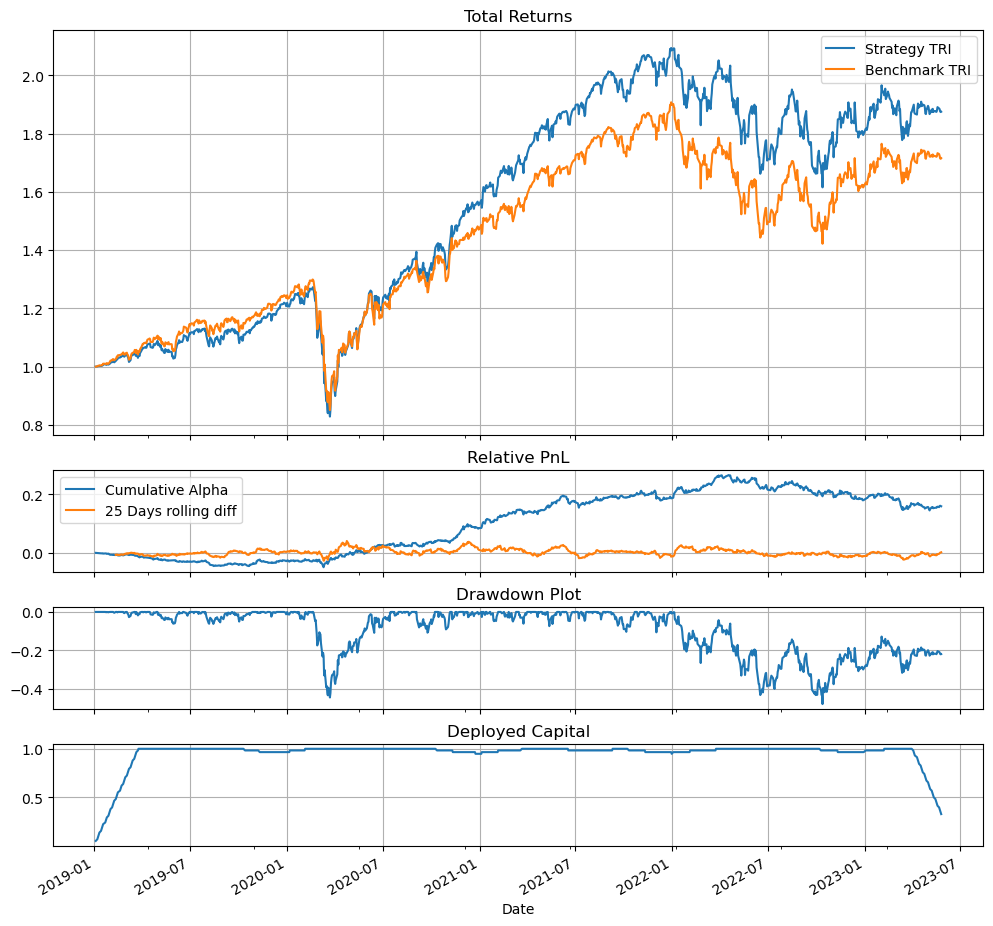

,Strategy,Benchmark
Expected Period Return,0.000658,0.000574
Ann. Sharpe,0.783612,0.697083
Ann. Sortino,1.084677,0.960880
Calmer,0.321475,0.269137
Max DD.,-0.478678,-0.485870
CAGR,0.153883,0.130765
Avg. Daily Turnover,0.029707,NaN


In [40]:
overall = overall_train_test(strat1, 13)
overall.report()

In [41]:
pd.to_pickle(strat1_method2, "strat1_method2.pkl")
pd.to_pickle(overall.quick_report(), "overall.pkl")

## <a id="S2">Strat 2 (Relationship)</a>

In [42]:
strat_2 = data.copy()
strat_2

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [43]:
strat_2["RPTOWNER_RELATIONSHIP"].unique()

array(['Officer', 'Director,Officer', 'Director', 'TenPercentOwner',
       'Director,Officer,TenPercentOwner', 'Other',
       'Director,TenPercentOwner', 'DirectorOther', 'OfficerOther',
       'Director,OfficerOther', 'Director,TenPercentOwnerOther',
       'Officer,TenPercentOwner', 'TenPercentOwnerOther',
       'Director,Officer,TenPercentOwnerOther', nan,
       'Officer,TenPercentOwnerOther'], dtype=object)

In [52]:
from collections import Counter

def overall_train_test_2(data, relationship, train_year = 13):
    optimal_holding_dict = {}
    for i in range(2006, 2006+train_year):
        daily_returns = strat_2_returns(data, i, relationship).sum()
        optimal_holding = daily_returns[daily_returns == daily_returns.max()].index[0]
        optimal_holding_dict.update({i : optimal_holding})

    values = list(optimal_holding_dict.values())
    counter = Counter(values)
    most_common = counter.most_common()

    # Find the lowest value among the most frequent values
    most_frequent_values = [value for value, count in most_common if count == most_common[0][1]]
    holding_period = min(most_frequent_values)    
    report_dict = {}
    for train in range(2019,2024):
        result = signal2portfolio(strat_2_returns(data, train, relationship))
        report_dict[train] = result
    combined_df = pd.concat(report_dict.values())
    return backtester.backtest(combined_df, delay=1, holding_period= holding_period)

def rolling_method_2(data, relationship):
    report_dict = {}
    for i in range(2006, 2023):
        daily_returns = strat_2_returns(data, i, relationship)
        total_returns = daily_returns.sum()[1:]
        optimal_holding = total_returns[total_returns == total_returns.max()].index[0] # this should return optimal holding for 2006
        result = backtester.backtest(signal2portfolio(daily_returns), delay=1, holding_period=optimal_holding)
        report_dict[i + 1] = result.quick_report()
    combined_df = pd.concat(report_dict.values(), keys = report_dict.keys())
    return combined_df.unstack().reorder_levels([1, 0], axis=1).stack()

In [45]:
def strat_2_returns(data, year, relationship): 
    first_data = data.groupby(["YEAR", "FILLINGDATE", "RPTOWNER_RELATIONSHIP", "ISSUERTRADINGSYMBOL"]).sum()
    initial_data = first_data.loc[(year,slice(None),relationship, slice(None))]
    real_signal = []
    for i in initial_data["SIGNAL"].values:
        if i > 0:
            real_signal.append(1)
        elif i == 0:
            real_signal.append(0)
        elif i < 0:
            real_signal.append(0) # this is 0 because we only consider about long only strat, just change to -1 when we want to do shorting also. 
    initial_data.insert(0, "REAL_SIGNAL", real_signal)
    each_returns = []
    for iterations in range(len(initial_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  initial_data.index[iterations][1]
        start_date = initial_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]
        # Import stock data
        # stock_data = import_stock_data(ticker, start_date, end_date) 
        for i in range(1, 91):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * initial_data["REAL_SIGNAL"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = initial_data.index)

In [46]:
strat2_method2_dir = rolling_method_2(strat_2, "Director")
strat2_method2_dir


Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.357284      2.023937                  NaN  0.143005   
     Strategy      1.430127      2.155101             0.028307  0.166386   
2008 Benchmark     0.120555      0.171279                  NaN  0.006422   
     Strategy      0.579689      0.834825             0.074237  0.081628   
2009 Benchmark    -0.959014     -1.306910                  NaN -0.366418   
     Strategy     -0.451134     -0.638803             0.025785 -0.234747   
2010 Benchmark     1.834981      2.924502                  NaN  0.418978   
     Strategy      1.948287      3.167328             0.024600  0.510733   
2011 Benchmark     1.375961      2.022542                  NaN  0.235467   
     Strategy      1.342482      1.941484             0.025388  0.235959   
2012 Benchmark     0.418400      0.576602                  NaN  0.067364   
     Strategy      0.318686      0.438017             0.030253  0.046771   
2013 Benchmark     1.274006      1.966118                  NaN  0.162932   
     Strategy      1.312274      2.005299             0.029449  0.170418   
2014 Benchmark     2.435162      3.600373                  NaN  0.268011   
     Strategy      2.518704      3.767736             0.028050  0.295598   
2015 Benchmark     1.338101      1.970178                  NaN  0.156295   
     Strategy      1.437894      2.100265             0.027552  0.186306   
2016 Benchmark    -0.034688     -0.045168                  NaN -0.015683   
     Strategy      0.018352      0.024054             0.028078 -0.010942   
2017 Benchmark     1.966340      3.036947                  NaN  0.201591   
     Strategy      1.924714      2.883565             0.026902  0.212694   
2018 Benchmark     2.627656      3.733106                  NaN  0.205671   
     Strategy      2.991475      4.255175             0.028880  0.265931   
2019 Benchmark     0.136718      0.187989                  NaN  0.009834   
     Strategy      0.483356      0.672055             0.028089  0.067486   
2020 Benchmark     2.112825      3.127616                  NaN  0.236357   
     Strategy      1.872928      2.749513             0.029427  0.226834   
2021 Benchmark     0.950016      1.327631                  NaN  0.245362   
     Strategy      1.289318      1.858466             0.027588  0.382525   
2022 Benchmark     1.244625      1.793769                  NaN  0.148017   
     Strategy      1.371920      1.981590             0.033522  0.171807   
2023 Benchmark    -0.408640     -0.565472                  NaN -0.119513   
     Strategy     -0.153895     -0.214737             0.368339 -0.068681   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.302121                0.000553 -0.109825  
     Strategy   1.638267                0.000637 -0.101562  
2008 Benchmark  0.043733                0.000076 -0.146839  
     Strategy   0.524791                0.000359 -0.155544  
2009 Benchmark -0.678319               -0.001503 -0.540185  
     Strategy  -0.477410               -0.000733 -0.491709  
2010 Benchmark  3.099209                0.001473 -0.135189  
     Strategy   3.369222                0.001743 -0.151588  
2011 Benchmark  1.573522                0.000895 -0.149643  
     Strategy   1.592864                0.000899 -0.148135  
2012 Benchmark  0.281541                0.000350 -0.239269  
     Strategy   0.181517                0.000280 -0.257665  
2013 Benchmark  1.558865                0.000633 -0.104520  
     Strategy   1.776658                0.000658 -0.095920  
2014 Benchmark  3.940043                0.000965 -0.068022  
     Strategy   5.208538                0.001054 -0.056753  
2015 Benchmark  1.583234                0.000603 -0.098719  
     Strategy   1.785334                0.000711 -0.104353  
2016 Benchmark -0.121161               -0.000020 -0.129437  
     Strategy  -0.070871                0.000012 -0.154396  
2017 Benchmark  3.241851                0.000752 -0.062184  
     Strategy

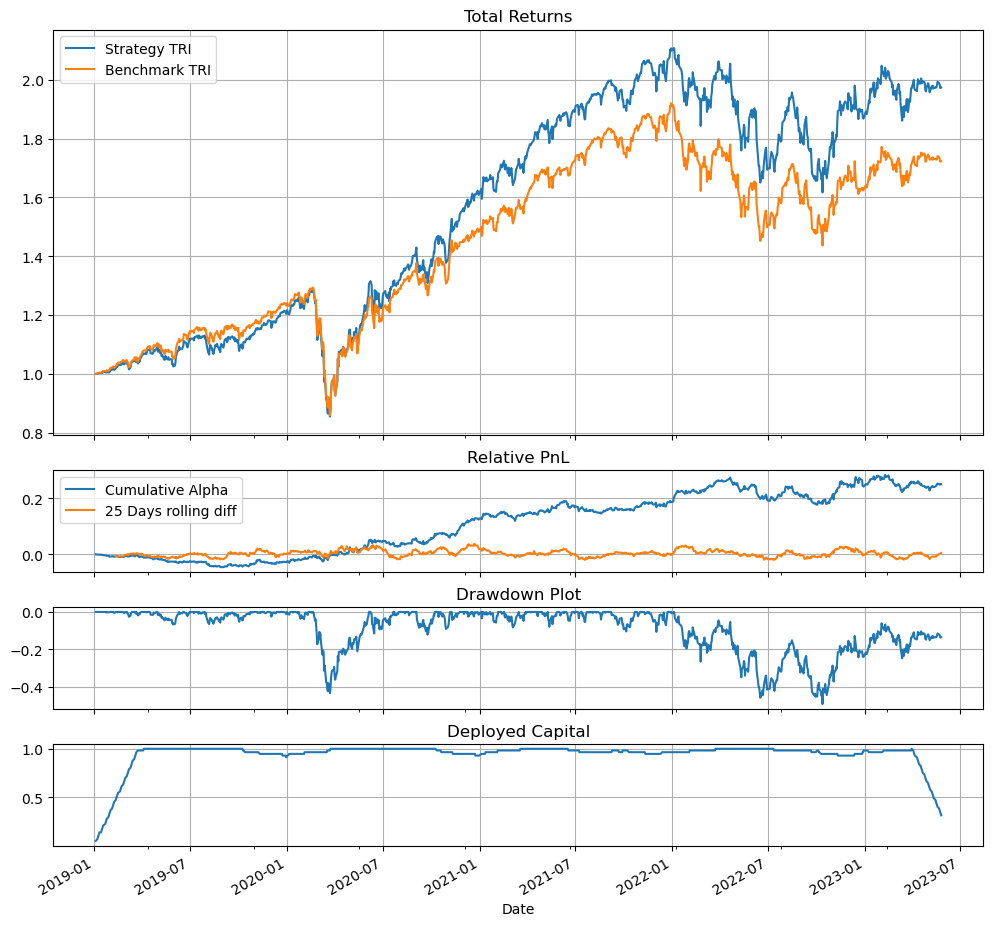

,Strategy,Benchmark
Expected Period Return,0.000708,0.000576
Ann. Sharpe,0.825495,0.708391
Ann. Sortino,1.155440,0.979542
Calmer,0.340882,0.272490
Max DD.,-0.491363,-0.484208
CAGR,0.167497,0.131942
Avg. Daily Turnover,0.032070,NaN


In [47]:
overall2_dir = overall_train_test_2(strat_2, "Director")
overall2_dir.report()

In [50]:
pd.to_pickle(strat2_method2_dir, "start2_method2_dir.pkl")
pd.to_pickle(overall2_dir.quick_report(), "overall2.pkl")

In [53]:
strat2_method2_tpo = rolling_method_2(strat_2, "TenPercentOwner")
strat2_method2_tpo


Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.192660      1.759359                  NaN  0.091674   
     Strategy      0.894529      1.331328             0.018199  0.071596   
2008 Benchmark     0.702056      1.023263                  NaN  0.080150   
     Strategy      0.425448      0.639107             0.232158  0.045221   
2009 Benchmark    -1.002121     -1.301801                  NaN -0.308248   
     Strategy     -0.495374     -0.639620             0.531333 -0.439580   
2010 Benchmark     1.668201      2.698383                  NaN  0.282382   
     Strategy      1.373124      2.213710             0.018152  0.309399   
2011 Benchmark     1.685016      2.510953                  NaN  0.171822   
     Strategy      1.415191      2.096260             0.017028  0.162696   
2012 Benchmark     0.549879      0.762354                  NaN  0.059811   
     Strategy      0.866870      1.235441             0.018379  0.094574   
2013 Benchmark     1.356760      2.151697                  NaN  0.103061   
     Strategy      2.048096      3.265224             0.016885  0.156707   
2014 Benchmark     2.547624      3.824399                  NaN  0.132212   
     Strategy      1.980699      2.894405             0.015335  0.126036   
2015 Benchmark     1.211845      1.844324                  NaN  0.104066   
     Strategy      1.295611      1.903013             0.019153  0.120571   
2016 Benchmark    -0.074886     -0.096945                  NaN -0.008935   
     Strategy      0.301509      0.432100             0.029851  0.026323   
2017 Benchmark     1.662659      2.464250                  NaN  0.094410   
     Strategy      0.992173      1.436372             0.023614  0.075815   
2018 Benchmark     3.341648      5.035652                  NaN  0.152851   
     Strategy      3.247403      4.737858             0.034084  0.210963   
2019 Benchmark    -0.045796     -0.066276                  NaN -0.010779   
     Strategy      1.096620      1.692139             0.104510  0.121461   
2020 Benchmark     2.383905      3.520207                  NaN  0.149140   
     Strategy      2.253094      3.434171             0.021537  0.167591   
2021 Benchmark     0.778314      1.080795                  NaN  0.130681   
     Strategy      0.955175      1.410398             0.014330  0.159727   
2022 Benchmark     0.981072      1.394227                  NaN  0.050209   
     Strategy      1.046013      1.550079             0.012004  0.053929   
2023 Benchmark    -0.027397     -0.038057                  NaN -0.013307   
     Strategy      0.876380      1.236377             0.058341  0.102180   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.111920                0.000360 -0.082446  
     Strategy   0.813374                0.000288 -0.088023  
2008 Benchmark  0.929045                0.000341 -0.086272  
     Strategy   0.512630                0.000218 -0.088214  
2009 Benchmark -0.623772               -0.001265 -0.494168  
     Strategy  -0.591426               -0.001315 -0.743255  
2010 Benchmark  2.142762                0.001038 -0.131784  
     Strategy   1.284736                0.001164 -0.240827  
2011 Benchmark  2.070670                0.000650 -0.082979  
     Strategy   1.797258                0.000625 -0.090525  
2012 Benchmark  0.491529                0.000257 -0.121684  
     Strategy   1.176023                0.000386 -0.080418  
2013 Benchmark  1.693709                0.000402 -0.060849  
     Strategy   2.228374                0.000589 -0.070324  
2014 Benchmark  4.849326                0.000499 -0.027264  
     Strategy   3.720572                0.000478 -0.033875  
2015 Benchmark  1.202575                0.000408 -0.086536  
     Strategy   1.657014                0.000469 -0.072764  
2016 Benchmark -0.136716               -0.000024 -0.065356  
     Strategy   0.378123                0.000120 -0.069616  
2017 Benchmark  3.042510                0.000366 -0.031030  
     Strategy

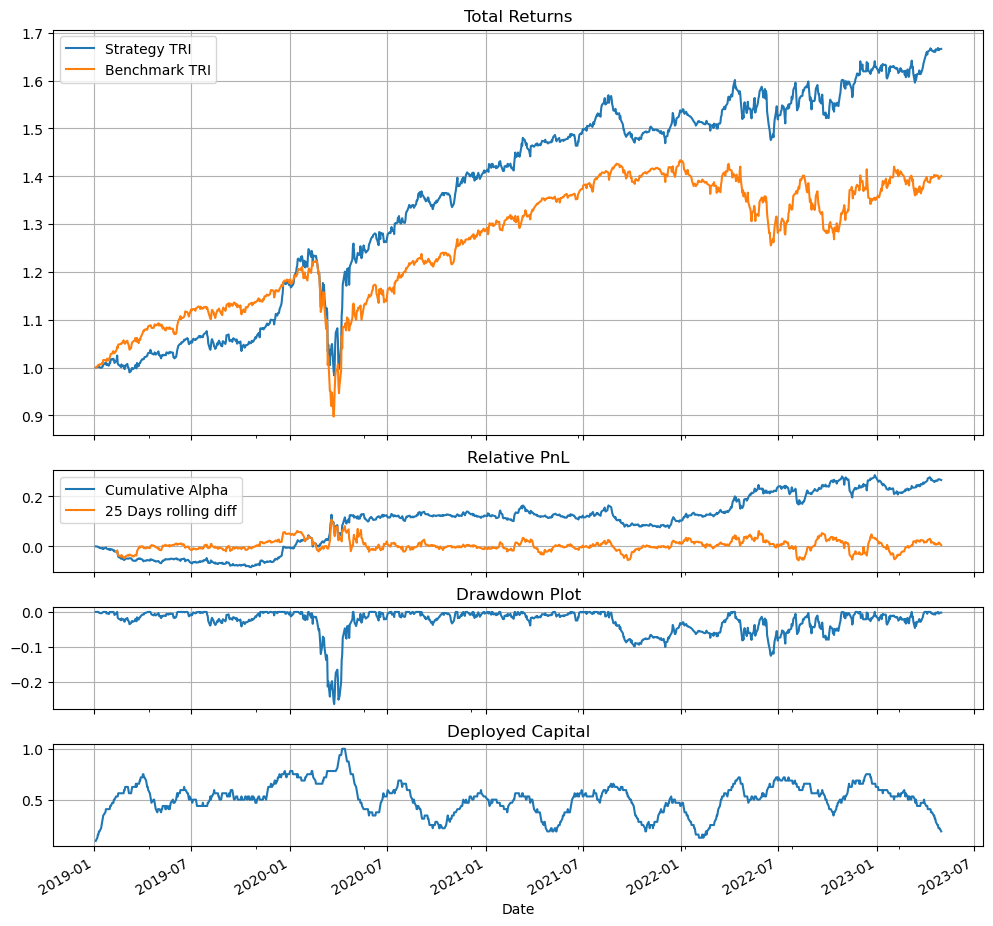

,Strategy,Benchmark
Expected Period Return,0.000500,0.000343
Ann. Sharpe,1.025215,0.671416
Ann. Sortino,1.452726,0.916046
Calmer,0.475743,0.248963
Max DD.,-0.263866,-0.325988
CAGR,0.125532,0.081159
Avg. Daily Turnover,0.030063,NaN


In [54]:
overall2_tpo = overall_train_test_2(strat_2, "TenPercentOwner")
overall2_tpo.report()

In [55]:
pd.to_pickle(strat2_method2_tpo, "strat2_method2_tpo.pkl")
pd.to_pickle(overall2_tpo.quick_report(), "overall2_tpo.pkl")

## <a id="S3">Strat 3 (Minimum Trade Size)</a>

In [56]:
strat_3 = data.copy()

In [57]:
trade_size = data["TRANS_SHARES"] * data["TRANS_PRICEPERSHARE"]
trade_size

0            16956.00
1            16962.00
2            14140.00
3             2829.00
4             5660.00
              ...    
1005926           NaN
1005927    1319471.20
1005928          0.00
1005929           NaN
1005930      85553.16
Length: 1005931, dtype: float64

In [58]:
import seaborn as sns

def outliers_checker(data):
    # Create the boxplot
    sns.boxplot(data = data.values)
    plt.xlabel('Data')
    plt.title('Boxplot')
    plt.show()

    # Identify outliers
    q1 = np.percentile(data.values, 25)
    q3 = np.percentile(data.values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[(data.values < lower_bound) | (data.values > upper_bound)]

    # Remove outliers and retain original labels
    data_cleaned = data[(data.values >= lower_bound) & (data.values <= upper_bound)]

    # Create boxplot for cleaned data
    sns.boxplot(data=data_cleaned)
    plt.xlabel('Data (No Outliers)')
    plt.title('Boxplot (No Outliers)')
    plt.show()
    return [outliers, data_cleaned] 

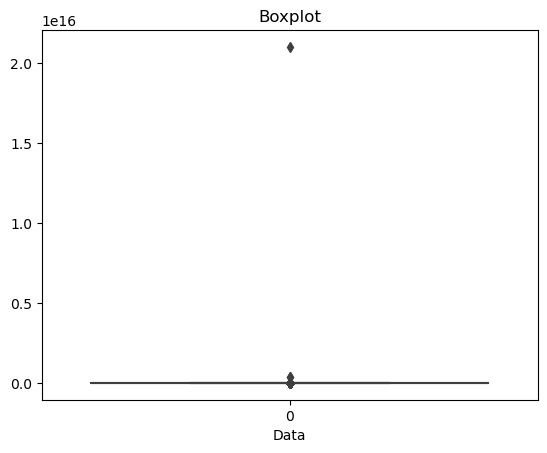

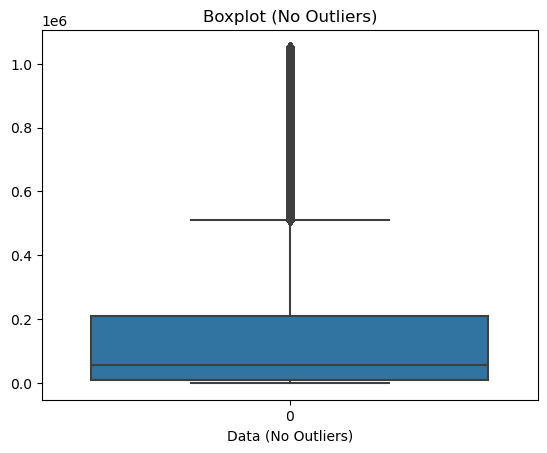

In [59]:
outlier, clean_data = outliers_checker(trade_size.dropna())

(array([526607., 108507.,  60627.,  40251.,  30537.,  23346.,  17699.,
         15017.,  12602.,  10984.]),
 array([      0. ,  105285.6,  210571.2,  315856.8,  421142.4,  526428. ,
         631713.6,  736999.2,  842284.8,  947570.4, 1052856. ]),
 <BarContainer object of 10 artists>)

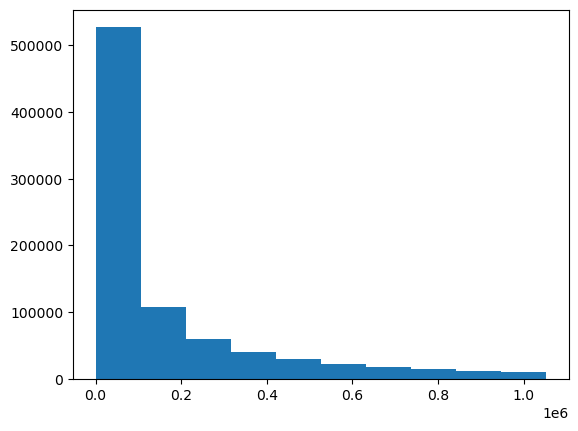

In [60]:
plt.hist(clean_data)

In [61]:
strat3 = data.copy()
strat3

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [62]:
strat3.insert(1, "TRADE_SIZE", trade_size)

In [63]:
strat3 = strat3.dropna(subset = ["TRADE_SIZE"]).reset_index(drop = True)
strat3

,ACCESSION_NUMBER,TRADE_SIZE,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,16956.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,16962.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,14140.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,2829.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,5660.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984885,0001209191-23-005986,63617.19,-1,2023,2023-02-01,01-FEB-2023,01-FEB-2023,Alphabet Inc.,GOOG,1738007,...,D,637.0,99.87,25282.0,D,4,True,True,CA,True
984886,0001140361-23-003959,644697.60,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,D,7824.0,82.40,28623.0,D,4,True,True,MD,True
984887,0001140361-23-003959,1319471.20,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
984888,0001209191-23-005991,0.00,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False


In [64]:
def strat3_data(data, threshold):
    new_data = data[data["TRADE_SIZE"] >= threshold]
    return new_data

In [65]:
strat_3 = strat3_data(strat3, 50000)
strat_3

,ACCESSION_NUMBER,TRADE_SIZE,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
5,0001219053-06-000062,62282.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,2200.0,28.31,50541.00,D,4,True,True,CA,True
9,0001219053-06-000062,59527.64,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,2099.0,28.36,47141.00,D,4,True,True,CA,True
14,0001219053-06-000062,142822.99,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,5099.0,28.01,70370.00,D,4,True,True,CA,True
19,0001219053-06-000062,87079.00,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,3100.0,28.09,66230.00,D,4,True,True,CA,True
29,0001219053-06-000062,248289.25,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,8789.0,28.25,54741.00,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984884,0001127602-23-002850,126015.00,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,PROGRESSIVE CORP/OH/,PGR,1665574,...,D,930.0,135.50,30041.26,D,4,True,True,OH,True
984885,0001209191-23-005986,63617.19,-1,2023,2023-02-01,01-FEB-2023,01-FEB-2023,Alphabet Inc.,GOOG,1738007,...,D,637.0,99.87,25282.00,D,4,True,True,CA,True
984886,0001140361-23-003959,644697.60,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,D,7824.0,82.40,28623.00,D,4,True,True,MD,True
984887,0001140361-23-003959,1319471.20,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,D,16013.0,82.40,36447.00,D,4,True,True,MD,True


In [66]:
strat3_method2 = rolling_method(strat_3)
strat3_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.343073      2.000225                  NaN  0.142298   
     Strategy      1.204921      1.794934             0.026709  0.139841   
2008 Benchmark     0.001024      0.001446                  NaN -0.013275   
     Strategy      0.315934      0.444968             0.042511  0.037997   
2009 Benchmark    -1.029542     -1.370412                  NaN -0.416155   
     Strategy     -0.534446     -0.748690             0.821080 -0.283610   
2010 Benchmark     1.839308      2.930817                  NaN  0.424419   
     Strategy      1.858195      2.962285             0.024501  0.416680   
2011 Benchmark     1.378271      2.027684                  NaN  0.236634   
     Strategy      1.520513      2.249226             0.026807  0.266323   
2012 Benchmark     0.428167      0.589905                  NaN  0.069827   
     Strategy      0.306437      0.420278             0.030607  0.043225   
2013 Benchmark     1.282530      1.980150                  NaN  0.164356   
     Strategy      1.352697      2.082488             0.029473  0.172656   
2014 Benchmark     2.437647      3.607827                  NaN  0.269204   
     Strategy      2.550250      3.811940             0.026346  0.285841   
2015 Benchmark     1.346410      1.983509                  NaN  0.157633   
     Strategy      1.496116      2.214585             0.026330  0.185890   
2016 Benchmark     0.313083      0.415843                  NaN  0.032280   
     Strategy      0.420531      0.565827             0.248889  0.057377   
2017 Benchmark     1.974613      3.050736                  NaN  0.202688   
     Strategy      1.960387      2.964625             0.026119  0.218438   
2018 Benchmark     2.606389      3.697306                  NaN  0.204966   
     Strategy      2.682858      3.766063             0.026398  0.229548   
2019 Benchmark     0.158418      0.218026                  NaN  0.012949   
     Strategy      0.433895      0.602444             0.027023  0.056068   
2020 Benchmark     2.176216      3.226253                  NaN  0.249344   
     Strategy      1.911783      2.780512             0.032621  0.224495   
2021 Benchmark     0.954006      1.333656                  NaN  0.247054   
     Strategy      1.342217      1.919798             0.026271  0.386143   
2022 Benchmark     2.274932      3.452662                  NaN  0.326714   
     Strategy      2.991732      4.668796             0.851912  0.470137   
2023 Benchmark    -0.480840     -0.662222                  NaN -0.135958   
     Strategy     -0.443861     -0.606398             0.347642 -0.125698   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.281255            5.503877e-04 -0.111062  
     Strategy   1.229938            5.467554e-04 -0.113698  
2008 Benchmark -0.078199            6.684891e-07 -0.169760  
     Strategy   0.256563            1.975554e-04 -0.148098  
2009 Benchmark -0.785006           -1.723904e-03 -0.530130  
     Strategy  -0.653634           -9.235843e-04 -0.433897  
2010 Benchmark  3.139458            1.489309e-03 -0.135189  
     Strategy   2.872770            1.464685e-03 -0.145045  
2011 Benchmark  1.576565            8.990349e-04 -0.150095  
     Strategy   1.928314            9.941028e-04 -0.138112  
2012 Benchmark  0.291754            3.604987e-04 -0.239334  
     Strategy   0.175192            2.599617e-04 -0.246729  
2013 Benchmark  1.569200            6.375083e-04 -0.104739  
     Strategy   1.691872            6.646632e-04 -0.102050  
2014 Benchmark  3.954106            9.692016e-04 -0.068082  
     Strategy   5.009050            1.021662e-03 -0.057065  
2015 Benchmark  1.594667            6.081077e-04 -0.098850  
     Strategy   1.764933            7.069389e-04 -0.105324  
2016 Benchmark  0.284204            1.884430e-04 -0.113581  
     Strategy   0.450379            2.767499e-04 -0.127396  
2017 Benchmark  3.259482            7.560151e-04 -0.062184  
     Strategy

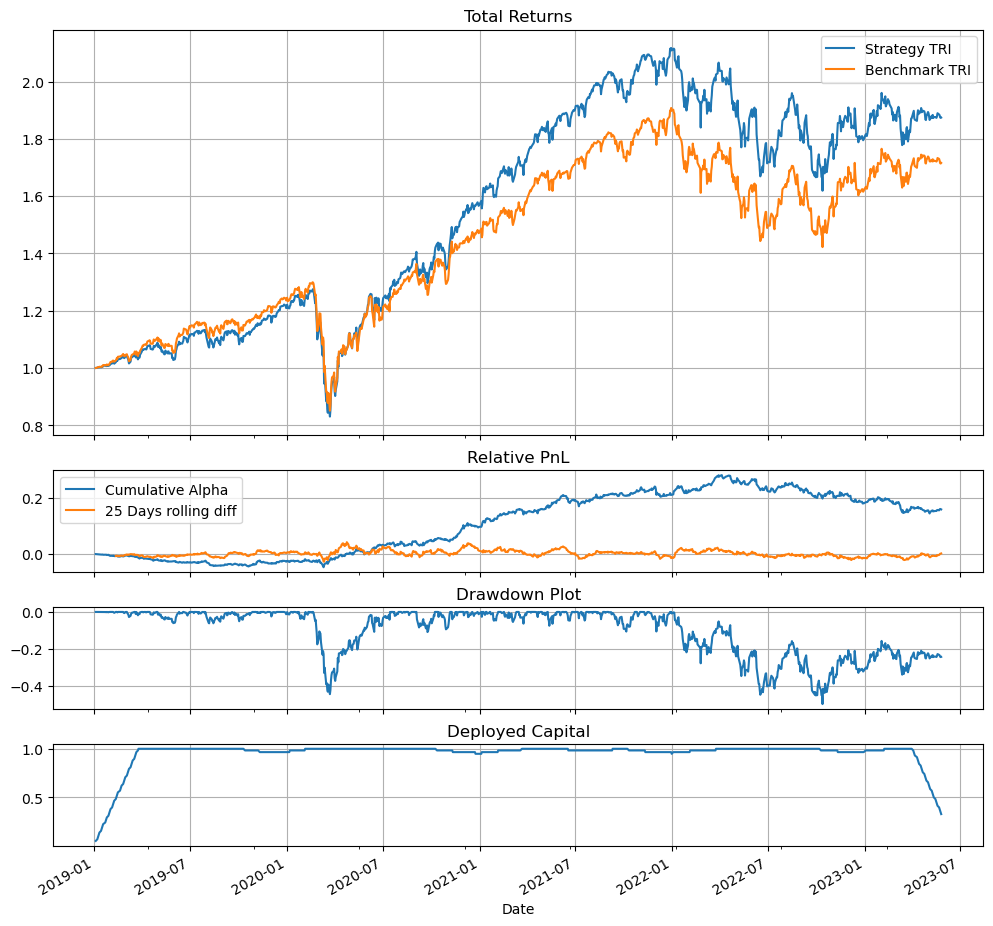

,Strategy,Benchmark
Expected Period Return,0.000658,0.000574
Ann. Sharpe,0.781236,0.697083
Ann. Sortino,1.079461,0.960880
Calmer,0.308387,0.269137
Max DD.,-0.498469,-0.485870
CAGR,0.153721,0.130765
Avg. Daily Turnover,0.029785,NaN


In [67]:
overall3 = overall_train_test(strat_3, 13)
overall3.report()

In [68]:
pd.to_pickle(strat3_method2, "strat3_method2.pkl")
pd.to_pickle(overall3.quick_report(), "overall3.pkl")

## <a id="S4">Strat 4</a>

In [69]:
strat4 = data.copy()
strat4

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005926,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005927,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005928,0001209191-23-005991,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,Pegula Kim S,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005929,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [70]:
PERCENT_OF_HOLDING = strat4["TRANS_SHARES"]/strat4["SHRS_OWND_FOLWNG_TRANS"]
PERCENT_OF_HOLDING

0          0.011082
1          0.011206
2          0.009427
3          0.001889
4          0.003792
             ...   
1005926    0.779642
1005927    0.439350
1005928    0.237810
1005929    0.491496
1005930    0.300534
Length: 1005931, dtype: float64

In [71]:
strat4.insert(1, "PERCENT_OF_HOLDING", PERCENT_OF_HOLDING)

In [72]:
strat4 = strat4.dropna(subset = ["PERCENT_OF_HOLDING"]).reset_index(drop = True)
strat4

,ACCESSION_NUMBER,PERCENT_OF_HOLDING,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,0.011082,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,0.011206,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,0.009427,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,0.001889,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,0.003792,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005832,0001140361-23-003959,0.779642,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
1005833,0001140361-23-003959,0.439350,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
1005834,0001209191-23-005991,0.237810,1,2023,2023-02-01,01-FEB-2023,31-JAN-2023,"REPUBLIC SERVICES, INC.",RSG,1713201,...,A,2702.0,0.00,11362.0,D,4,True,True,AZ,False
1005835,0001701605-23-000031,0.491496,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [73]:
strat4["PERCENT_OF_HOLDING"].describe()

count    1.005837e+06
mean              inf
std               NaN
min      0.000000e+00
25%      3.115502e-03
50%      2.995239e-02
75%      1.689931e-01
max               inf
Name: PERCENT_OF_HOLDING, dtype: float64

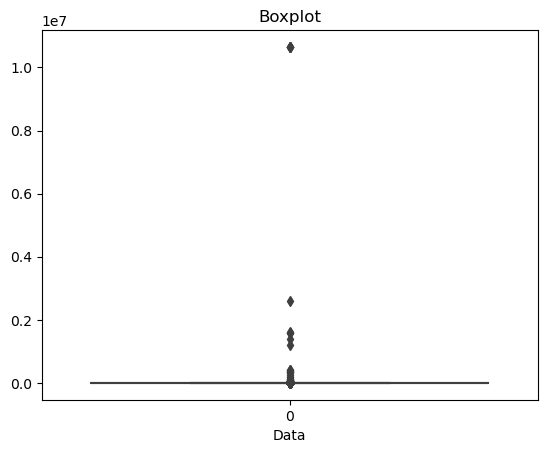

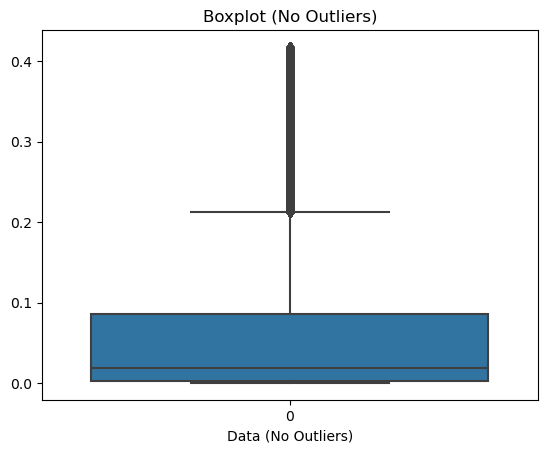

In [74]:
strat4_outlier, strat4_cleandata = outliers_checker(strat4["PERCENT_OF_HOLDING"])

In [75]:
strat4_outlier

53         1.000000
54              inf
79         0.529412
81              inf
83         1.000000
             ...   
1005824    0.757658
1005825    0.470069
1005832    0.779642
1005833    0.439350
1005835    0.491496
Name: PERCENT_OF_HOLDING, Length: 133582, dtype: float64

(array([548472., 101349.,  60201.,  42854.,  32252.,  25256.,  19853.,
         17092.,  13615.,  11311.]),
 array([0.        , 0.04178061, 0.08356123, 0.12534184, 0.16712246,
        0.20890307, 0.25068368, 0.2924643 , 0.33424491, 0.37602552,
        0.41780614]),
 <BarContainer object of 10 artists>)

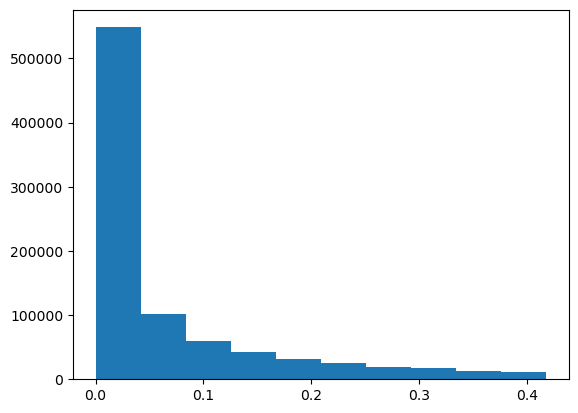

In [76]:
plt.hist(strat4_cleandata)

In [77]:
def strat4_data(data, threshold):
    new_data = data[data["PERCENT_OF_HOLDING"] >= threshold]
    return new_data

In [78]:
strat_4 = strat4_data(strat4, 0.2)

In [79]:
strat4_method2 = rolling_method(strat_4)
strat4_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.343073      2.000225                  NaN  0.142298   
     Strategy      1.235277      1.832931             0.027600  0.137866   
2008 Benchmark     0.008679      0.012253                  NaN -0.012052   
     Strategy      0.307222      0.433149             0.042521  0.036423   
2009 Benchmark    -1.024831     -1.379172                  NaN -0.419160   
     Strategy     -0.385798     -0.549103             1.748481 -0.258970   
2010 Benchmark     1.839308      2.930817                  NaN  0.424419   
     Strategy      1.968611      3.200327             0.025130  0.471956   
2011 Benchmark     1.375961      2.022542                  NaN  0.235467   
     Strategy      1.579094      2.373470             0.026573  0.278177   
2012 Benchmark     0.430403      0.593667                  NaN  0.069925   
     Strategy      0.300579      0.412220             0.027352  0.041764   
2013 Benchmark     1.332254      2.059927                  NaN  0.172727   
     Strategy      1.331409      2.044312             0.032296  0.173423   
2014 Benchmark     2.437647      3.607827                  NaN  0.269204   
     Strategy      2.519107      3.771030             0.026842  0.281383   
2015 Benchmark     1.346410      1.983509                  NaN  0.157633   
     Strategy      1.419267      2.085592             0.027112  0.171710   
2016 Benchmark     0.272283      0.360954                  NaN  0.026845   
     Strategy      0.505143      0.678975             0.203668  0.070078   
2017 Benchmark     1.974613      3.050736                  NaN  0.202688   
     Strategy      2.006498      3.079263             0.027372  0.219914   
2018 Benchmark     2.606389      3.697306                  NaN  0.204966   
     Strategy      2.650456      3.731234             0.027261  0.221961   
2019 Benchmark     0.158418      0.218026                  NaN  0.012949   
     Strategy      0.410142      0.570011             0.027863  0.052387   
2020 Benchmark     2.149129      3.183553                  NaN  0.243764   
     Strategy      1.785230      2.585419             0.030850  0.202806   
2021 Benchmark     0.954006      1.333656                  NaN  0.247054   
     Strategy      1.373375      1.994960             0.027429  0.397571   
2022 Benchmark     2.197710      3.323024                  NaN  0.313380   
     Strategy      2.835575      4.319152             0.600242  0.453818   
2023 Benchmark    -0.574856     -0.791900                  NaN -0.158002   
     Strategy     -0.444864     -0.608794             0.917755 -0.125434   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.281255                0.000550 -0.111062  
     Strategy   1.319813                0.000538 -0.104459  
2008 Benchmark -0.070365                0.000006 -0.171283  
     Strategy   0.219725                0.000189 -0.165769  
2009 Benchmark -0.797347               -0.001736 -0.525694  
     Strategy  -0.661282               -0.000703 -0.391617  
2010 Benchmark  3.139458                0.001489 -0.135189  
     Strategy   3.325658                0.001624 -0.141914  
2011 Benchmark  1.573522                0.000895 -0.149643  
     Strategy   2.001104                0.001031 -0.139012  
2012 Benchmark  0.292429                0.000359 -0.239119  
     Strategy   0.165076                0.000253 -0.252999  
2013 Benchmark  1.643734                0.000667 -0.105082  
     Strategy   1.614977                0.000668 -0.107384  
2014 Benchmark  3.954106                0.000969 -0.068082  
     Strategy   4.765167                0.001008 -0.059050  
2015 Benchmark  1.594667                0.000608 -0.098850  
     Strategy   1.563413                0.000658 -0.109830  
2016 Benchmark  0.236615                0.000164 -0.113454  
     Strategy   0.557619                0.000322 -0.125674  
2017 Benchmark  3.259482                0.000756 -0.062184  
     Strategy

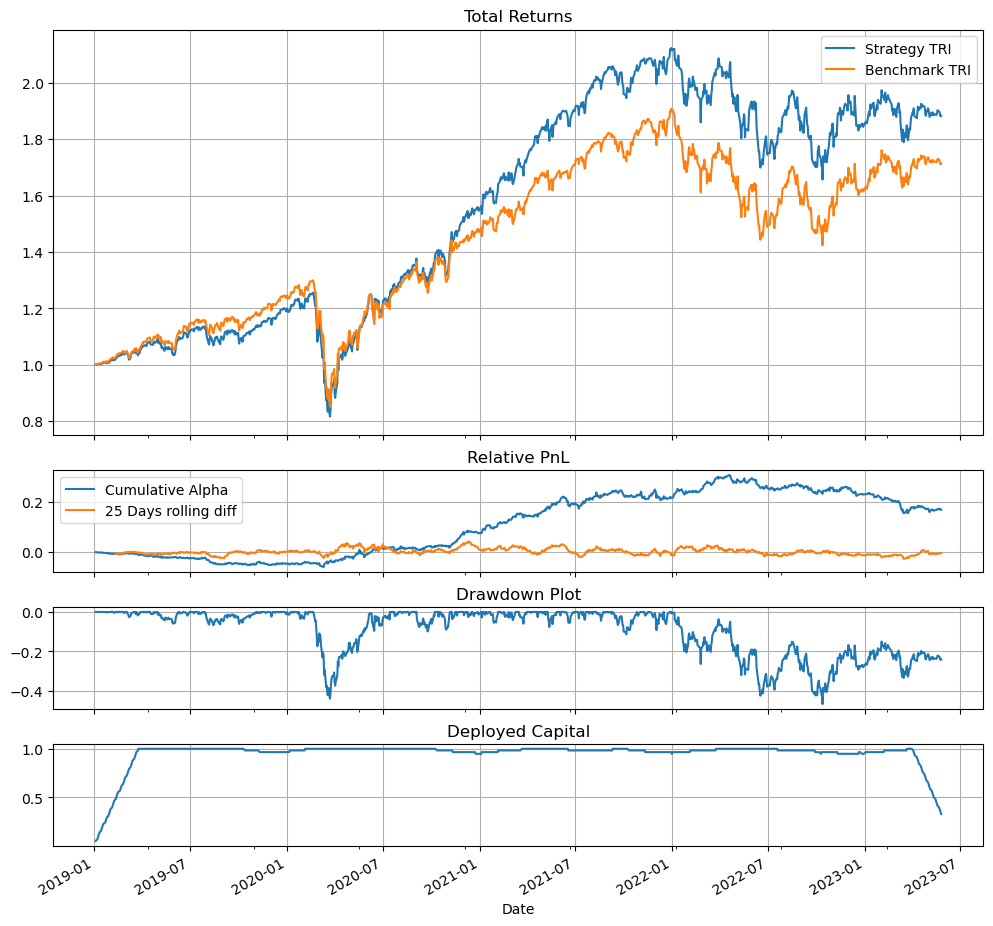

,Strategy,Benchmark
Expected Period Return,0.000659,0.000573
Ann. Sharpe,0.796574,0.696982
Ann. Sortino,1.106218,0.960183
Calmer,0.331759,0.269282
Max DD.,-0.467005,-0.484196
CAGR,0.154933,0.130385
Avg. Daily Turnover,0.031153,NaN


In [80]:
overall4 = overall_train_test(strat_4, 13)
overall4.report()

In [81]:
pd.to_pickle(strat4_method2, "strat4_method2.pkl")
pd.to_pickle(overall4.quick_report(), "overall4.pkl")

## <a id="S5">Strat 5</a>

In [82]:
strat_5 = data.copy()

In [83]:
def strat_5_returns(data, year):
    first_groupby = data.groupby(["YEAR", "FILLINGDATE", "ISSUERTRADINGSYMBOL", "RPTOWNERNAME"]).sum()
    first_groupby = first_groupby.loc[(year, slice(None), slice(None), slice(None))]
    unique_signal = []
    for i in first_groupby["SIGNAL"].values:
        if i > 0:
            unique_signal.append(1)
        elif i == 0:
            unique_signal.append(0)
        elif i < 0:
            unique_signal.append(0)
    first_groupby.insert(0, "UNIQUE_SIGNAL", unique_signal)
    second_groupby = first_groupby.groupby(["FILLINGDATE", "ISSUERTRADINGSYMBOL"]).sum()
    real_signal = []
    for i in second_groupby["UNIQUE_SIGNAL"].values:
        if i > 0:
            real_signal.append(1)
        elif i == 0:
            real_signal.append(0)
        elif i < 0:
            real_signal.append(0)
    second_groupby.insert(0, "REAL_SIGNAL", real_signal)
    each_returns = []
    for iterations in range(len(second_groupby.index)):
        stock_returns = []
        # Example usage 
        ticker =  second_groupby.index[iterations][1]
        start_date = second_groupby.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]
        # Import stock data
        # stock_data = import_stock_data(ticker, start_date, end_date) 
        for i in range(1, 91):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * second_groupby["REAL_SIGNAL"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = second_groupby.index)

In [84]:
strat5_method2 = rolling_method(strat_5)
strat5_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.343073      2.000225                  NaN  0.142298   
     Strategy      1.271209      1.905506             0.026058  0.147663   
2008 Benchmark     0.115806      0.164296                  NaN  0.005576   
     Strategy      0.435473      0.614947             0.062949  0.056596   
2009 Benchmark    -1.029542     -1.370412                  NaN -0.416155   
     Strategy     -0.293970     -0.416217             0.813143 -0.212707   
2010 Benchmark     1.839308      2.930817                  NaN  0.424419   
     Strategy      1.952072      3.147020             0.024124  0.477888   
2011 Benchmark     1.375961      2.022542                  NaN  0.235467   
     Strategy      1.462071      2.157047             0.024833  0.256666   
2012 Benchmark     0.418849      0.577275                  NaN  0.067541   
     Strategy      0.312654      0.429091             0.028923  0.044873   
2013 Benchmark     1.282530      1.980150                  NaN  0.164356   
     Strategy      1.364854      2.095211             0.029048  0.176500   
2014 Benchmark     2.437647      3.607827                  NaN  0.269204   
     Strategy      2.577422      3.858648             0.026127  0.290249   
2015 Benchmark     1.346410      1.983509                  NaN  0.157633   
     Strategy      1.499784      2.220660             0.026199  0.185831   
2016 Benchmark    -0.039303     -0.051186                  NaN -0.016440   
     Strategy     -0.034237     -0.044865             0.026629 -0.018111   
2017 Benchmark     1.974613      3.050736                  NaN  0.202688   
     Strategy      2.046503      3.107744             0.026082  0.229628   
2018 Benchmark     2.606389      3.697306                  NaN  0.204966   
     Strategy      2.686646      3.779989             0.026228  0.226639   
2019 Benchmark     0.158418      0.218026                  NaN  0.012949   
     Strategy      0.445918      0.619823             0.026962  0.057382   
2020 Benchmark     2.196570      3.261142                  NaN  0.252895   
     Strategy      1.972787      2.876215             0.035834  0.232259   
2021 Benchmark     0.954006      1.333656                  NaN  0.247054   
     Strategy      1.322386      1.894867             0.026213  0.380476   
2022 Benchmark     1.315448      1.897852                  NaN  0.161632   
     Strategy      1.469700      2.113596             0.044559  0.187085   
2023 Benchmark    -0.480840     -0.662222                  NaN -0.135958   
     Strategy     -0.378575     -0.521104             0.347036 -0.110935   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.281255                0.000550 -0.111062  
     Strategy   1.357038                0.000574 -0.108813  
2008 Benchmark  0.037014                0.000074 -0.150645  
     Strategy   0.425787                0.000265 -0.132922  
2009 Benchmark -0.785006               -0.001724 -0.530130  
     Strategy  -0.483032               -0.000522 -0.440359  
2010 Benchmark  3.139458                0.001489 -0.135189  
     Strategy   3.217221                0.001645 -0.148541  
2011 Benchmark  1.573522                0.000895 -0.149643  
     Strategy   1.801933                0.000964 -0.142439  
2012 Benchmark  0.282227                0.000351 -0.239313  
     Strategy   0.180391                0.000268 -0.248752  
2013 Benchmark  1.569200                0.000638 -0.104739  
     Strategy   1.690164                0.000678 -0.104428  
2014 Benchmark  3.954106                0.000969 -0.068082  
     Strategy   5.085459                0.001035 -0.057074  
2015 Benchmark  1.594667                0.000608 -0.098850  
     Strategy   1.761550                0.000707 -0.105493  
2016 Benchmark -0.126148               -0.000023 -0.130327  
     Strategy  -0.126820               -0.000022 -0.142810  
2017 Benchmark  3.259482                0.000756 -0.062184  
     Strategy

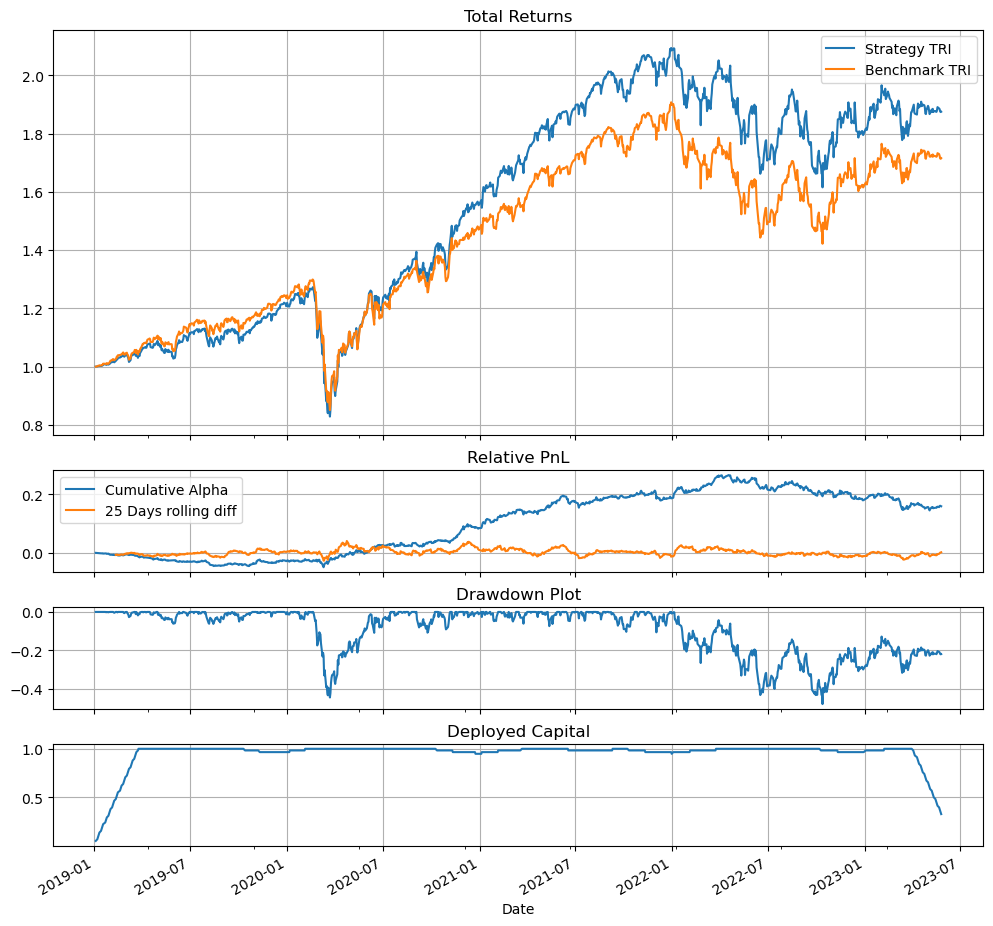

,Strategy,Benchmark
Expected Period Return,0.000658,0.000574
Ann. Sharpe,0.783612,0.697083
Ann. Sortino,1.084677,0.960880
Calmer,0.321475,0.269137
Max DD.,-0.478678,-0.485870
CAGR,0.153883,0.130765
Avg. Daily Turnover,0.029707,NaN


In [85]:
overall5 = overall_train_test(strat_5, 13)
overall5.report()

In [86]:
pd.to_pickle(strat5_method2, "strat5_method2.pkl")
pd.to_pickle(overall5.quick_report(), "overall5.pkl")

## <a id="S6">Strat 6 (Co-location)</a>

In [87]:
strat_6 = data[data["Co-location"] == True]
strat_6 = strat_6.reset_index(drop = True)
strat_6

,ACCESSION_NUMBER,SIGNAL,YEAR,FILLINGDATE,FILING_DATE,PERIOD_OF_REPORT,ISSUERNAME,ISSUERTRADINGSYMBOL,RPTOWNERCIK,RPTOWNERNAME,...,TRANS_ACQUIRED_DISP_CD,TRANS_SHARES,TRANS_PRICEPERSHARE,SHRS_OWND_FOLWNG_TRANS,DIRECT_INDIRECT_OWNERSHIP,DOCUMENT_TYPE,S&P500,R1000,State,Co-location
0,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.26,54141.0,D,4,True,True,CA,True
1,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,600.0,28.27,53541.0,D,4,True,True,CA,True
2,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,500.0,28.28,53041.0,D,4,True,True,CA,True
3,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,100.0,28.29,52941.0,D,4,True,True,CA,True
4,0001219053-06-000062,-1,2006,2006-03-31,31-MAR-2006,29-MAR-2006,NETFLIX INC,NFLX,1219596,DILLON THOMAS R,...,D,200.0,28.30,52741.0,D,4,True,True,CA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821565,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,7824.0,82.40,28623.0,D,4,True,True,MD,True
821566,0001140361-23-003959,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,A,40900.0,NaN,52460.0,D,4,True,True,MD,True
821567,0001140361-23-003959,-1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Constellation Energy Corp,CEG,1897905,MCHUGH JAMES,...,D,16013.0,82.40,36447.0,D,4,True,True,MD,True
821568,0001701605-23-000031,1,2023,2023-02-01,01-FEB-2023,30-JAN-2023,Baker Hughes Co,BKR,1710299,Camilleri Kurt,...,A,5866.0,NaN,11935.0,D,4,True,True,TX,True


In [88]:
strat6_method2 = rolling_method(strat_6)
strat6_method2

Ann. Sharpe  Ann. Sortino  Avg. Daily Turnover      CAGR  \
2007 Benchmark     1.343073      2.000225                  NaN  0.142298   
     Strategy      1.253060      1.890890             0.025881  0.146559   
2008 Benchmark     0.101964      0.144794                  NaN  0.003380   
     Strategy      0.473907      0.671724             0.068354  0.062367   
2009 Benchmark    -1.029542     -1.370412                  NaN -0.416155   
     Strategy     -0.253112     -0.357651             0.814054 -0.196256   
2010 Benchmark     1.839308      2.930817                  NaN  0.424419   
     Strategy      1.941813      3.124744             0.024072  0.475256   
2011 Benchmark     1.375961      2.022542                  NaN  0.235467   
     Strategy      1.504575      2.230756             0.024681  0.267989   
2012 Benchmark     0.418849      0.577275                  NaN  0.067541   
     Strategy      0.260895      0.357438             0.028912  0.033199   
2013 Benchmark     1.289413      1.989746                  NaN  0.164815   
     Strategy      1.381131      2.124335             0.027474  0.174503   
2014 Benchmark     2.437647      3.607827                  NaN  0.269204   
     Strategy      2.572517      3.851067             0.026185  0.288036   
2015 Benchmark     1.346410      1.983509                  NaN  0.157633   
     Strategy      1.501829      2.228518             0.026182  0.186473   
2016 Benchmark    -0.038166     -0.049712                  NaN -0.016285   
     Strategy     -0.040717     -0.053338             0.026021 -0.019005   
2017 Benchmark     1.974613      3.050736                  NaN  0.202688   
     Strategy      2.081590      3.169338             0.026087  0.230062   
2018 Benchmark     2.606389      3.697306                  NaN  0.204966   
     Strategy      2.672586      3.775403             0.026306  0.224827   
2019 Benchmark     0.110825      0.152377                  NaN  0.006077   
     Strategy      0.459424      0.638898             0.032276  0.060865   
2020 Benchmark     2.196570      3.261142                  NaN  0.252895   
     Strategy      1.985377      2.888472             0.035899  0.232404   
2021 Benchmark     0.954006      1.333656                  NaN  0.247054   
     Strategy      1.288668      1.844683             0.026277  0.362819   
2022 Benchmark     1.807691      2.668255                  NaN  0.239402   
     Strategy      2.552077      3.854520             0.144989  0.358185   
2023 Benchmark    -0.480840     -0.662222                  NaN -0.135958   
     Strategy     -0.363428     -0.500616             0.347299 -0.108911   

                  Calmer  Expected Period Return   Max DD.  
2007 Benchmark  1.281255                0.000550 -0.111062  
     Strategy   1.332865                0.000570 -0.109958  
2008 Benchmark  0.023094                0.000065 -0.146372  
     Strategy   0.497092                0.000286 -0.125463  
2009 Benchmark -0.785006               -0.001724 -0.530130  
     Strategy  -0.425531               -0.000444 -0.461202  
2010 Benchmark  3.139458                0.001489 -0.135189  
     Strategy   3.390020                0.001638 -0.140193  
2011 Benchmark  1.573522                0.000895 -0.149643  
     Strategy   1.949466                0.001001 -0.137468  
2012 Benchmark  0.282227                0.000351 -0.239313  
     Strategy   0.131691                0.000222 -0.252097  
2013 Benchmark  1.578467                0.000639 -0.104415  
     Strategy   1.745909                0.000670 -0.099950  
2014 Benchmark  3.954106                0.000969 -0.068082  
     Strategy   5.015940                0.001028 -0.057424  
2015 Benchmark  1.594667                0.000608 -0.098850  
     Strategy   1.826409                0.000709 -0.102098  
2016 Benchmark -0.124962               -0.000022 -0.130317  
     Strategy  -0.131135               -0.000026 -0.144926  
2017 Benchmark  3.259482                0.000756 -0.062184  
     Strategy

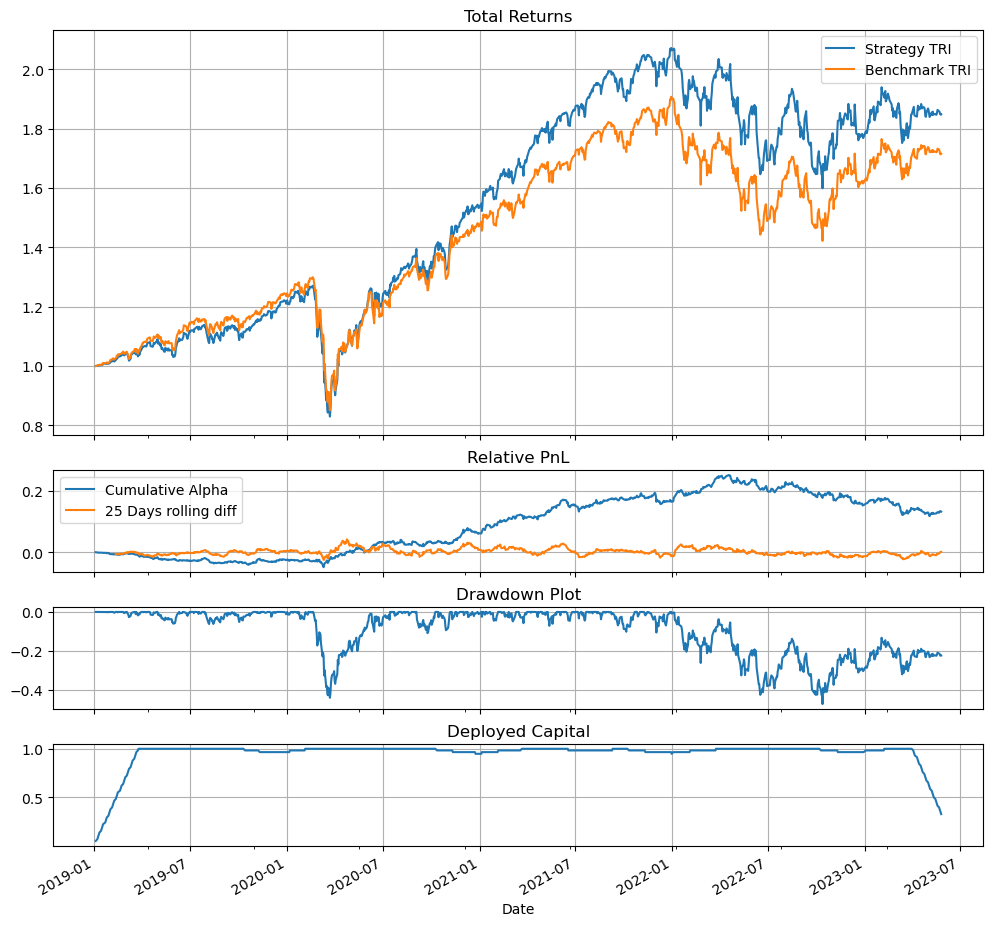

,Strategy,Benchmark
Expected Period Return,0.000644,0.000574
Ann. Sharpe,0.771142,0.697083
Ann. Sortino,1.066811,0.960880
Calmer,0.317223,0.269137
Max DD.,-0.473185,-0.485870
CAGR,0.150105,0.130765
Avg. Daily Turnover,0.029733,NaN


In [89]:
overall6 = overall_train_test(strat_6, 13)
overall6.report()

In [90]:
pd.to_pickle(strat6_method2, "strat6_method2.pkl")
pd.to_pickle(overall6.quick_report(), "overall6.pkl")

Combining all the strategies into one table

In [91]:
s1_m1 = pd.read_pickle("overall.pkl")
s2_m1_dir = pd.read_pickle("overall2.pkl")
s2_m1_tpo = pd.read_pickle("overall2_tpo.pkl")
s3_m1 = pd.read_pickle("overall3.pkl")
s4_m1 = pd.read_pickle("overall4.pkl")
s5_m1 = pd.read_pickle("overall5.pkl")
s6_m1 = pd.read_pickle("overall6.pkl")

combined_method1 = pd.concat([pd.Series(s1_m1.iloc[ : ,1]), pd.Series(s1_m1.iloc[ : ,0], name = "Strat 1"),  pd.Series(s2_m1_dir.iloc[ : ,0], name = "Strat 2 Dir"), \
    pd.Series(s2_m1_tpo.iloc[ : ,0], name = "Strat 2 TPO"), pd.Series(s3_m1.iloc[ : ,0], name = "Strat 3"),\
    pd.Series(s4_m1.iloc[ : ,0], name = "Strat 4"), pd.Series(s5_m1.iloc[ : ,0], name = "Strat 5"),\
        pd.Series(s6_m1.iloc[ : ,0], name = "Strat 6")], axis = 1)
combined_method1

,Benchmark,Strat 1,Strat 2 Dir,Strat 2 TPO,Strat 3,Strat 4,Strat 5,Strat 6
Expected Period Return,0.000574,0.000658,0.000708,0.000500,0.000658,0.000659,0.000658,0.000644
Ann. Sharpe,0.697083,0.783612,0.825495,1.025215,0.781236,0.796574,0.783612,0.771142
Ann. Sortino,0.960880,1.084677,1.155440,1.452726,1.079461,1.106218,1.084677,1.066811
Calmer,0.269137,0.321475,0.340882,0.475743,0.308387,0.331759,0.321475,0.317223
Max DD.,-0.485870,-0.478678,-0.491363,-0.263866,-0.498469,-0.467005,-0.478678,-0.473185
CAGR,0.130765,0.153883,0.167497,0.125532,0.153721,0.154933,0.153883,0.150105
Avg. Daily Turnover,NaN,0.029707,0.032070,0.030063,0.029785,0.031153,0.029707,0.029733


In [94]:
def converter(name):
    data = pd.read_pickle(name)
    summary = data.mean(level = 1)[ : : -1].T
    summary = summary.reindex(["Expected Period Return", "Ann. Sharpe", "Ann. Sortino", "Calmer", "Max DD.", "CAGR", "Avg. Daily Turnover"])
    return summary

s1_m2 = converter("strat1_method2.pkl")
s2_m2_dir = converter("start2_method2_dir.pkl")
s2_m2_tpo = converter("strat2_method2_tpo.pkl")
s3_m2 = converter("strat3_method2.pkl")
s4_m2 = converter("strat4_method2.pkl")
s5_m2 = converter("strat5_method2.pkl")
s6_m2 = converter("strat6_method2.pkl")

combined_method2 = pd.concat([pd.Series(s1_m2.iloc[ : ,1]), pd.Series(s1_m2.iloc[ : ,0], name = "Strat 1"),  pd.Series(s2_m2_dir.iloc[ : ,0], name = "Strat 2 Dir"), \
    pd.Series(s2_m2_tpo.iloc[ : ,0], name = "Strat 2 TPO"), pd.Series(s3_m2.iloc[ : ,0], name = "Strat 3"),\
    pd.Series(s4_m2.iloc[ : ,0], name = "Strat 4"), pd.Series(s5_m2.iloc[ : ,0], name = "Strat 5"),\
        pd.Series(s6_m2.iloc[ : ,0], name = "Strat 6")], axis = 1)

combined_method2

,Benchmark,Strat 1,Strat 2 Dir,Strat 2 TPO,Strat 3,Strat 4,Strat 5,Strat 6
Expected Period Return,0.000443,0.000599,0.000616,0.000382,0.000619,0.000635,0.000599,0.000632
Ann. Sharpe,1.047961,1.183100,1.190304,1.210151,1.257068,1.258607,1.183100,1.251305
Ann. Sortino,1.567149,1.755187,1.763584,1.815786,1.876099,1.879656,1.755187,1.867011
Calmer,1.476272,1.673977,1.704210,1.712394,1.841342,1.869284,1.673977,1.879269
Max DD.,-0.160861,-0.153240,-0.159825,-0.124283,-0.152329,-0.150968,-0.153240,-0.151519
CAGR,0.116478,0.153411,0.159218,0.092071,0.163609,0.166284,0.153411,0.163493
Avg. Daily Turnover,NaN,0.095350,0.050850,0.069700,0.155367,0.226256,0.095350,0.101821


# <a id='S7'>Strat 7 Winning Insider</a>

In [ ]:
SP_500=SNP.copy()
#dataframe now contains long only insiders
SP_500=SP_500[(SP_500['TRANS_ACQUIRED_DISP_CD'] == 'A')]
SP_500

In [ ]:
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data

def add_accuracy_column(data):
    filing_dates = data.index.tolist()
    accuracy_values = []

    for filing_date in filing_dates:
        next_days = data.loc[filing_date: filing_date + pd.DateOffset(days=Days)]
        if len(next_days) < Days:
            accuracy_values.append(0)
        else:
            returns = next_days['Close'].pct_change(periods=Days)
            if any(returns > threshold):
                accuracy_values.append(1)
            else:
                accuracy_values.append(0)

    data['Accuracy'] = accuracy_values
    return data

In [ ]:
import datetime

def process_and_group_data(dataframe):
    # Ensure 'TRANS_SHARES' are float numbers
    dataframe['TRANS_SHARES'] = dataframe['TRANS_SHARES'].astype(float)

    # Group by 'ACCESSION_NUMBER' and calculate the sum of 'TRANS_SHARES'
    shares_sum_df = dataframe.groupby('ACCESSION_NUMBER').agg({
        'TRANS_SHARES': 'sum'
    }).reset_index()

    # Merge this dataframe back into the original dataframe
    merged_df = pd.merge(dataframe, shares_sum_df, on='ACCESSION_NUMBER', suffixes=('', '_sum'))

    # Drop duplicates to retain only the first row for each 'ACCESSION_NUMBER'
    merged_df = merged_df.drop_duplicates(subset='ACCESSION_NUMBER', keep='first')

    # Drop the original 'TRANS_SHARES' column and rename the summed column
    merged_df = merged_df.drop(columns='TRANS_SHARES')
    merged_df = merged_df.rename(columns={'TRANS_SHARES_sum': 'TRANS_SHARES'})

    # Group by 'RPTOWNERNAME' and calculate the mean values
    grouped_df = merged_df.groupby('RPTOWNERNAME').mean().reset_index()

    # Get the first 'FILING_DATE' and 'PERIOD_OF_REPORT' for each 'RPTOWNERNAME'
    date_report_df = merged_df.groupby('RPTOWNERNAME').agg({
        'FILING_DATE': 'first',
        'PERIOD_OF_REPORT': 'first',
        'RPTOWNER_RELATIONSHIP': 'first'
    }).reset_index()

    # Merge these two dataframes on 'RPTOWNERNAME'
    final_df = pd.merge(grouped_df, date_report_df, on='RPTOWNERNAME')

    return final_df

In [ ]:
def calculate_accuracy(dataframe, ticker, threshold=0.1, Days=100, cumulative_return_limit=0.08):
    filing_dates = pd.to_datetime(list(set(dataframe[dataframe['ISSUERTRADINGSYMBOL'] == ticker]['FILING_DATE'])))

    accuracy_dict = {}

    for filing_date in filing_dates:
        start_date = filing_date
        end_date = filing_date + pd.DateOffset(days=2*Days)
        stock_data = get_stock_data(ticker, start_date, end_date)

        returns = np.cumsum(np.log(stock_data['Close'] / stock_data['Close'].shift(1)))
        if any(returns >= threshold):
            accuracy_dict[filing_date] = 1
        else:
            accuracy_dict[filing_date] = 0

    dataframe.loc[dataframe['ISSUERTRADINGSYMBOL'] == ticker, 'Accuracy'] = dataframe.loc[
        dataframe['ISSUERTRADINGSYMBOL'] == ticker, 'FILING_DATE'].map(accuracy_dict).replace({np.nan: 0}).astype(int)

    dataframe = process_and_group_data(dataframe)
    dataframe["ticker"]=ticker
    dataframe["FILING_DATE"] =pd.to_datetime(dataframe["FILING_DATE"])
    dataframe.sort_values("FILING_DATE")

    # Split the dataframe into training and testing sets
    train_data = dataframe[
        (dataframe["FILING_DATE"] >= train_start_date) &
        (dataframe["FILING_DATE"] <= train_end_date)
    ]

    test_data = dataframe[
        (dataframe["FILING_DATE"] >= test_start_date) &
        (dataframe["FILING_DATE"] <= test_end_date)
    ]

    plot_file_name = f"{ticker}_plot.png"
    results_dict = {}

    if len(train_data[train_data['Accuracy']>accuracy_threshold])>0:
        total_trades = len(test_data)
        test_data['FILING_DATE'] = pd.to_datetime(test_data['FILING_DATE'])
        msft = yf.download(ticker, start=test_data['FILING_DATE'].min(), end=datetime.date.today())
        msft = msft.resample('D').ffill()
        test_data = test_data.set_index('FILING_DATE').resample('D').last()
        data = msft.join(test_data)
        data['long'] = np.where(data['RPTOWNERNAME'].notna(), 1, 0)
        data['long'] = data['long'].rolling(window=100, min_periods=1).max()
        data['log_return'] = np.log(data['Close'] / data['Close'].shift())
        data['cumulative_log_return'] = data['log_return'].cumsum()
        data['cumulative_return'] = np.exp(data['cumulative_log_return']) - 1

        # Implement the strategy, adjusting for the cumulative return limit
        hit_limit_positions = data[data['cumulative_return'] >= cumulative_return_limit].index
        limit_hit_date = min(hit_limit_positions) if len(hit_limit_positions) > 0 else None
        if limit_hit_date:
            next_trading_day = data.index[data.index.get_loc(limit_hit_date) + 1]
            data.loc[next_trading_day, 'long'] = 0

        cumulative_log_return = data['cumulative_log_return'].iloc[-1]
        cumulative_return = data['cumulative_return'].iloc[-1]

        long_positions = data[data['long'] == 1]
        entry_positions = long_positions[long_positions['PERIOD_OF_REPORT'].notna()]
        closing_positions = entry_positions.index + DateOffset(days=100)
        closing_positions = closing_positions[closing_positions <= data.index[-1]]
        
        entry_dates = entry_positions.index
        closing_dates = []

        for date in entry_dates:
            loc = data.index.get_loc(date)
            if loc + 100 < len(data):
                closing_date = data.index[loc + 100]
                closing_dates.append(closing_date)
            else:
                # If it's within 100 positions from the end, set closing date to the last date in the DataFrame
                closing_date = data.index[-1]
                closing_dates.append(closing_date)

        wins = data.loc[closing_dates, 'cumulative_log_return'].values > data.loc[entry_dates, 'cumulative_log_return'].values
        wins = wins.sum()

        win_rate = wins / total_trades

        plt.style.use('ggplot')  # use 'ggplot' style for the plot
        plt.figure(figsize=(14,7))
        # Increase the line width, change the line style, and change the color to black
        plt.plot(data['Close'], label=f'{ticker} price', linewidth=2, linestyle='-.', color='black')
        # Change the marker style and size
        plt.scatter(entry_positions.index, entry_positions['Close'], color='gold', marker='o', s=500, label='Entry Position')
        plt.scatter(long_positions.index, long_positions['Close'], color='pink', label='Long positions', s=100,alpha = 0.3)
        plt.scatter(closing_positions, data.loc[closing_positions, 'Close'], color='blue', marker='v', s=500, label='Closing Position')
        # Add a grid
        plt.grid(True, linestyle='--', alpha=0.6)
        # Increase the size of labels and title
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Price', fontsize=14)
        plt.title(f'Chart of {ticker}', fontsize=16)
        # Increase the size of legend and move it to the bottom right
        plt.legend(fontsize=12, loc='lower right')

        # Display statistics on the plot
        plt.text(0.02, 0.95, f'Win Rate: {win_rate:.2%}', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.02, 0.90, f'Cumulative Return: {cumulative_return:.2%}', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.02, 0.85, f'Cumulative Log Return: {cumulative_log_return:.2%}', transform=plt.gca().transAxes, fontsize=12)

        plt.savefig(plot_file_name)
        plt.close()

        results_dict[ticker] = {
            'cumulative_log_return': cumulative_log_return,
            'cumulative_return': cumulative_return,
            'win_rate': win_rate,
            'entry_dates': entry_dates.tolist(),
            'plot_file_name': plot_file_name
        }
    return results_dict


In [ ]:
accuracy_dates = {}
return_threshold = 0.1
look_forward_period_days=120
accuracy_threshold= 0.7
cumulative_return_limit=0.08

# Define the training and testing date ranges
train_start_date = pd.to_datetime('2006-01-01')
train_end_date = pd.to_datetime('2017-12-31')
test_start_date = pd.to_datetime('2018-01-01')
test_end_date = pd.to_datetime('2023-12-31')

In [ ]:
sp500_tickers = list(sp_500['Symbol'])

### Execute this to simulate winning insider strat and capture a snap of testing performance as .png

In [ ]:
results_dict = {}
for i in sp500_tickers:
    result = calculate_accuracy(SP_500[(SP_500['ISSUERTRADINGSYMBOL'] == i)],
                                i,
                                threshold=return_threshold,
                                Days=look_forward_period_days,
                                cumulative_return_limit=cumulative_return_limit)

    results_dict.update(result)